In [ ]:
COLLABORATORS_NAME = "Tanvir Ahmed Khan Nibir, Priyankan Biswas"
COLLABORATORS_ID = "22201103, 22201604"

# Library Import and Dataset Loading

In [ ]:
!pip -q install torch torchaudio
!pip -q install scikit-learn matplotlib tqdm

In [ ]:
import os, random, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt

In [ ]:
import os, random, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:

from torchaudio.datasets import SPEECHCOMMANDS

root = "./data_speechcommands"
os.makedirs(root, exist_ok=True)

In [ ]:
!pip -q install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 61.9 MB/s eta 0:00:00


In [ ]:
TARGET_LABELS = ["up", "down", "left", "right"]
label_to_idx = {l: i for i, l in enumerate(TARGET_LABELS)}
idx_to_label = {i: l for l, i in label_to_idx.items()}

train_base = SPEECHCOMMANDS(root, subset="training", download=True)
val_base   = SPEECHCOMMANDS(root, subset="validation", download=True)
test_base  = SPEECHCOMMANDS(root, subset="testing", download=True)

100%|██████████| 2.26G/2.26G [01:43<00:00, 23.5MB/s]


Only taking the data with labels up, down, left, right.

# Filtering

In [ ]:
class FilteredSpeechCommands(Dataset):
    def __init__(self, base_ds, allowed_labels, max_items=None, seed=42):
        self.allowed = set(allowed_labels)
        self.idxs = [i for i in range(len(base_ds)) if base_ds[i][2] in self.allowed]
        if max_items is not None and len(self.idxs) > max_items:
            rng = np.random.default_rng(seed)
            self.idxs = rng.choice(self.idxs, size=max_items, replace=False).tolist()

        self.base = base_ds

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        return self.base[self.idxs[i]]

train_set = FilteredSpeechCommands(train_base, TARGET_LABELS, max_items=3000)
val_set   = FilteredSpeechCommands(val_base,   TARGET_LABELS, max_items=3000)
test_set  = FilteredSpeechCommands(test_base,  TARGET_LABELS, max_items=3000)

print("Using labels:", TARGET_LABELS)
print("Train/Val/Test sizes:", len(train_set), len(val_set), len(test_set))

Using labels: ['up', 'down', 'left', 'right']
Train/Val/Test sizes: 3000 1442 1639


#Creating Spectogram Data

In [ ]:
TARGET_SR = 16000
TARGET_LEN = 16000

def pad_or_crop_1d(x, target_len=TARGET_LEN):
    T = x.shape[-1]
    if T == target_len:
        return x
    if T < target_len:
        return F.pad(x, (0, target_len - T))
    return x[:target_len]

N_FFT = 1024
HOP = 512
WIN = 1024

spectrogram_tf=torchaudio.transforms.Spectrogram(n_fft=N_FFT,
                                                 hop_length=HOP,
                                                 win_length=WIN,
                                                 power=2.0,
                                                 center=True)


def make_stft_features(wave_1d):
    """
    wave_1d: (T,) float tensor
    returns: (1, F, TT) log-power spectrogram
    """
    spec = spectrogram_tf(wave_1d.unsqueeze(0))  # (1, F, TT)
    spec = torch.log1p(spec)
    return spec

In [ ]:
class SpecDataset(Dataset):
    def __init__(self, base_ds, label_to_idx):
        self.base = base_ds
        self.label_to_idx = label_to_idx
        self.resamplers = {}

    def _resample(self, wav, sr):
        if sr == TARGET_SR:
            return wav
        if sr not in self.resamplers:
            self.resamplers[sr] = torchaudio.transforms.Resample(sr, TARGET_SR)
        return self.resamplers[sr](wav)

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        wav, sr, label, *_ = self.base[idx]  # wav: (1, T)
        wav = self._resample(wav, sr)[0]     # (T,)



        wav = (wav - wav.mean()) / (wav.std() + 1e-6)

        # fixed length
        wav = pad_or_crop_1d(wav, TARGET_LEN)

        # STFT
        spec = make_stft_features(wav)       # (1, F, TT)

        y = self.label_to_idx[label]         # 0..3
        return wav.float(), spec.float(), torch.tensor(y, dtype=torch.long)

train_ds = SpecDataset(train_set, label_to_idx)
val_ds   = SpecDataset(val_set,  label_to_idx)
test_ds  = SpecDataset(test_set,  label_to_idx)

x_raw, x_spec, y = train_ds[0]
print("raw:", x_raw.shape, "spec:", x_spec.shape, "y:", y.item(), idx_to_label[y.item()])

raw: torch.Size([16000]) spec: torch.Size([1, 513, 32]) y: 2 left


#Data Loading

In [ ]:
BATCH = 128
NUM_WORKERS = 0

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# Defining Models

In [ ]:
num_classes = 4

In [ ]:
class RawOnlyModel(nn.Module):
    def __init__(self, in_ch=1, n_classes=num_classes):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv1d(in_ch, 64, kernel_size=80, stride=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )

        self.block2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )

        self.block3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )

        self.block4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.fc = nn.Linear(512, n_classes)

    def forward(self, raw, spec):
        x = raw
        if x.dim() == 2:
            x = x.unsqueeze(1)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.flatten(1)
        return self.fc(x)

raw_model = RawOnlyModel(n_classes=num_classes).to(device)
print("Raw Model:")
print(raw_model)

Raw Model:
RawOnlyModel(
  (block1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(80,), stride=(4,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(512, eps=1

In [ ]:
class SpecOnlyModel(nn.Module):
    def __init__(self, in_ch=1, n_classes=num_classes):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.block_custom = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(512, n_classes)

    def forward(self, raw, spec):

        x = spec
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block_custom(x)
        x = self.block4(x)
        x = x.flatten(1)
        return self.fc(x)

spec_model = SpecOnlyModel(n_classes=num_classes).to(device)
print("Updated Spec Model with Batch Normalization:")
print(spec_model)

Updated Spec Model with Batch Normalization:
SpecOnlyModel(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_custom): Sequential(
    (0): Conv2d(128, 256, kernel_

In [ ]:
class TwoStreamFusionModel(nn.Module):
    def __init__(self, raw_model, spec_model, num_classes, embedding_dim=128):
        super(TwoStreamFusionModel, self).__init__()
        self.raw_features = nn.Sequential(
            raw_model.block1,
            raw_model.block2,
            raw_model.block3,
            raw_model.block4,
            nn.Flatten()
        )

        self.raw_proj = nn.Linear(512, embedding_dim)
        self.spec_features = nn.Sequential(
            spec_model.block1,
            spec_model.block2,
            spec_model.block3,
            spec_model.block_custom,
            spec_model.block4,
            nn.Flatten()
        )

        self.spec_proj = nn.Linear(512, embedding_dim)
        self.fusion_head = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, raw, spec):
        if raw.dim() == 2:
            raw = raw.unsqueeze(1)
        raw_feat = self.raw_features(raw)
        zr = self.raw_proj(raw_feat)
        spec_feat = self.spec_features(spec)
        zs = self.spec_proj(spec_feat)
        z = torch.cat([zr, zs], dim=1)
        logits = self.fusion_head(z)
        return logits


raw_model_instance = RawOnlyModel(n_classes=4).to(device)
spec_model_instance = SpecOnlyModel(n_classes=4).to(device)
fusion_model = TwoStreamFusionModel(
    raw_model=raw_model_instance,
    spec_model=spec_model_instance,
    num_classes=4,
    embedding_dim=128
).to(device)

print(fusion_model)

TwoStreamFusionModel(
  (raw_features): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 64, kernel_size=(80,), stride=(4,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,)

# Training

In [ ]:
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import torch.nn.functional as F

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds, all_y = [], []
    total_loss, total = 0.0, 0

    for raw, spec, y in loader:
        raw, spec, y = raw.to(device), spec.to(device), y.to(device)
        logits = model(raw, spec)
        loss = F.cross_entropy(logits, y)

        total_loss += loss.item() * y.size(0)
        total += y.size(0)

        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_y.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_y = np.concatenate(all_y)

    acc = (all_preds == all_y).mean()
    macro_f1 = f1_score(all_y, all_preds, average="macro")
    return total_loss/total, acc, macro_f1, all_y, all_preds

def train_model(model, train_loader, val_loader, epochs=15, lr=1e-3, model_name="Model"):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    best_val_f1 = -1
    best_state = None
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for ep in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for raw, spec, y in tqdm(train_loader, desc=f"{model_name} Epoch {ep}/{epochs}"):
            raw, spec, y = raw.to(device), spec.to(device), y.to(device)

            opt.zero_grad()
            logits = model(raw, spec)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            opt.step()

            running_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {ep}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f} | val_macroF1={val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state:
        model.load_state_dict(best_state)

    return model, history

# Raw Audio Model

In [ ]:
# Parameters
LR = 1e-3
TARGET_LABELS = ['left', 'right', 'up', 'down']

# Raw Audio Model
raw_model, raw_hist = train_model(RawOnlyModel(n_classes=4), train_loader, val_loader, 15, LR, "RawOnly")

RawOnly Epoch 1/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1: train_loss=0.9649 | val_loss=1.3369 | val_acc=0.3523 | val_macroF1=0.2468


RawOnly Epoch 2/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2: train_loss=0.6342 | val_loss=0.7667 | val_acc=0.7129 | val_macroF1=0.7091


RawOnly Epoch 3/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3: train_loss=0.5285 | val_loss=0.8589 | val_acc=0.6741 | val_macroF1=0.6666


RawOnly Epoch 4/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4: train_loss=0.4712 | val_loss=0.5817 | val_acc=0.7961 | val_macroF1=0.7921


RawOnly Epoch 5/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5: train_loss=0.4091 | val_loss=0.5599 | val_acc=0.8183 | val_macroF1=0.8189


RawOnly Epoch 6/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6: train_loss=0.3615 | val_loss=0.8162 | val_acc=0.7101 | val_macroF1=0.7093


RawOnly Epoch 7/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7: train_loss=0.3409 | val_loss=0.5588 | val_acc=0.7767 | val_macroF1=0.7806


RawOnly Epoch 8/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8: train_loss=0.2955 | val_loss=0.5586 | val_acc=0.8079 | val_macroF1=0.8025


RawOnly Epoch 9/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9: train_loss=0.2956 | val_loss=0.6441 | val_acc=0.7809 | val_macroF1=0.7812


RawOnly Epoch 10/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10: train_loss=0.2533 | val_loss=0.4524 | val_acc=0.8384 | val_macroF1=0.8359


RawOnly Epoch 11/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11: train_loss=0.2460 | val_loss=0.3606 | val_acc=0.8883 | val_macroF1=0.8882


RawOnly Epoch 12/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12: train_loss=0.2242 | val_loss=0.3506 | val_acc=0.8918 | val_macroF1=0.8925


RawOnly Epoch 13/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13: train_loss=0.2139 | val_loss=0.7604 | val_acc=0.7282 | val_macroF1=0.6966


RawOnly Epoch 14/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14: train_loss=0.1846 | val_loss=0.4938 | val_acc=0.8266 | val_macroF1=0.8227


RawOnly Epoch 15/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15: train_loss=0.1578 | val_loss=0.3527 | val_acc=0.8877 | val_macroF1=0.8883


In [ ]:
# Parameters
EPOCHS = 15
LR = 1e-3
TARGET_LABELS = ['left', 'right', 'up', 'down']

# Spec Model
spec_model, spec_hist = train_model(SpecOnlyModel(n_classes=4), train_loader, val_loader, EPOCHS, LR, "SpecOnly")

# Fusion model
fusion_model, fusion_hist = train_model(TwoStreamFusionModel(raw_model, spec_model, 4), train_loader, val_loader, EPOCHS, LR, "Fusion")


SpecOnly Epoch 1/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1: train_loss=1.0055 | val_loss=1.4720 | val_acc=0.3433 | val_macroF1=0.2627


SpecOnly Epoch 2/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2: train_loss=0.6940 | val_loss=0.8430 | val_acc=0.6928 | val_macroF1=0.6955


SpecOnly Epoch 3/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3: train_loss=0.5644 | val_loss=0.7194 | val_acc=0.7060 | val_macroF1=0.6795


SpecOnly Epoch 4/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4: train_loss=0.4764 | val_loss=1.2637 | val_acc=0.5693 | val_macroF1=0.5282


SpecOnly Epoch 5/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5: train_loss=0.4164 | val_loss=0.5979 | val_acc=0.7649 | val_macroF1=0.7529


SpecOnly Epoch 6/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6: train_loss=0.3414 | val_loss=2.3956 | val_acc=0.4133 | val_macroF1=0.3645


SpecOnly Epoch 7/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7: train_loss=0.2583 | val_loss=1.5172 | val_acc=0.6449 | val_macroF1=0.6319


SpecOnly Epoch 8/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8: train_loss=0.2433 | val_loss=1.6245 | val_acc=0.5693 | val_macroF1=0.4825


SpecOnly Epoch 9/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9: train_loss=0.2059 | val_loss=0.8869 | val_acc=0.7219 | val_macroF1=0.6680


SpecOnly Epoch 10/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10: train_loss=0.1760 | val_loss=0.4501 | val_acc=0.8509 | val_macroF1=0.8510


SpecOnly Epoch 11/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11: train_loss=0.1424 | val_loss=0.6214 | val_acc=0.8148 | val_macroF1=0.8135


SpecOnly Epoch 12/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12: train_loss=0.1168 | val_loss=0.2779 | val_acc=0.9001 | val_macroF1=0.8974


SpecOnly Epoch 13/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13: train_loss=0.0856 | val_loss=0.5309 | val_acc=0.8398 | val_macroF1=0.8438


SpecOnly Epoch 14/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14: train_loss=0.1012 | val_loss=1.3979 | val_acc=0.6436 | val_macroF1=0.6538


SpecOnly Epoch 15/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15: train_loss=0.0971 | val_loss=0.5554 | val_acc=0.8058 | val_macroF1=0.7994


Fusion Epoch 1/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5417 | val_loss=0.4000 | val_acc=0.8620 | val_macroF1=0.8622


Fusion Epoch 2/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2: train_loss=0.1940 | val_loss=2.2736 | val_acc=0.5499 | val_macroF1=0.4393


Fusion Epoch 3/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3: train_loss=0.1400 | val_loss=0.3987 | val_acc=0.8599 | val_macroF1=0.8621


Fusion Epoch 4/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4: train_loss=0.1156 | val_loss=0.3986 | val_acc=0.8835 | val_macroF1=0.8820


Fusion Epoch 5/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5: train_loss=0.1008 | val_loss=0.6163 | val_acc=0.8433 | val_macroF1=0.8451


Fusion Epoch 6/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6: train_loss=0.0895 | val_loss=0.7163 | val_acc=0.7947 | val_macroF1=0.7960


Fusion Epoch 7/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7: train_loss=0.0933 | val_loss=0.6894 | val_acc=0.8419 | val_macroF1=0.8441


Fusion Epoch 8/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8: train_loss=0.0613 | val_loss=0.2748 | val_acc=0.9175 | val_macroF1=0.9157


Fusion Epoch 9/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9: train_loss=0.0660 | val_loss=2.0534 | val_acc=0.6304 | val_macroF1=0.6211


Fusion Epoch 10/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10: train_loss=0.0886 | val_loss=0.2558 | val_acc=0.9286 | val_macroF1=0.9287


Fusion Epoch 11/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11: train_loss=0.0523 | val_loss=0.3983 | val_acc=0.8883 | val_macroF1=0.8856


Fusion Epoch 12/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12: train_loss=0.0729 | val_loss=6.2484 | val_acc=0.3391 | val_macroF1=0.2462


Fusion Epoch 13/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13: train_loss=0.0753 | val_loss=0.3559 | val_acc=0.8870 | val_macroF1=0.8821


Fusion Epoch 14/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14: train_loss=0.0810 | val_loss=0.3198 | val_acc=0.9189 | val_macroF1=0.9188


Fusion Epoch 15/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15: train_loss=0.0555 | val_loss=5.1576 | val_acc=0.4001 | val_macroF1=0.3517


# Evaluation and Reports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history['train_loss'], label='Train')
    ax1.plot(history['val_loss'], label='Val')
    ax1.set_title(f'{model_name} Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='Train')
    ax2.plot(history['val_acc'], label='Val')
    ax2.set_title(f'{model_name} Accuracy')
    ax2.legend()
    plt.show()

def run_final_evaluation(models_dict, test_loader, target_names):
    results = []

    for name, model in models_dict.items():
        loss, acc, f1, y_true, y_pred = evaluate(model, test_loader)
        results.append({'Model': name, 'Accuracy': acc, 'Macro F1': f1})

        print(f"\n--- {name} Classification Report ---")
        print(classification_report(y_true, y_pred, target_names=target_names))

        # Confusion Matrix
        fig, ax = plt.subplots(figsize=(5, 5))
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=target_names, cmap='Blues', ax=ax)
        ax.set_title(f"Confusion Matrix: {name}")
        plt.show()

    return results

def plot_comparison_histogram(results):
    models = [r['Model'] for r in results]
    accs = [r['Accuracy'] for r in results]
    f1s = [r['Macro F1'] for r in results]

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, accs, width, label='Accuracy', color='skyblue')
    ax.bar(x + width/2, f1s, width, label='Macro F1', color='salmon')

    ax.set_ylabel('Scores')
    ax.set_title('Performance Comparison of All Three Models')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    plt.show()

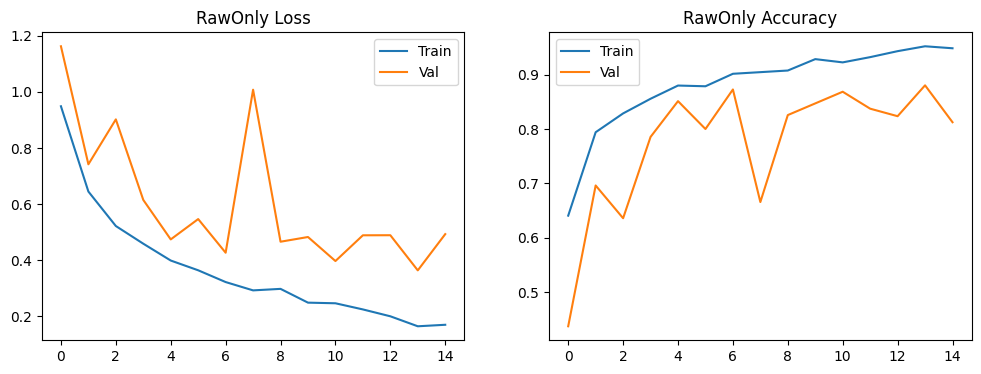

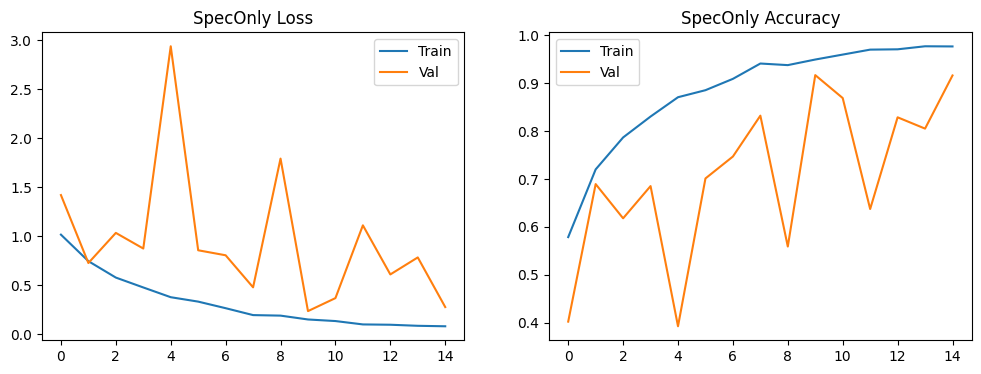

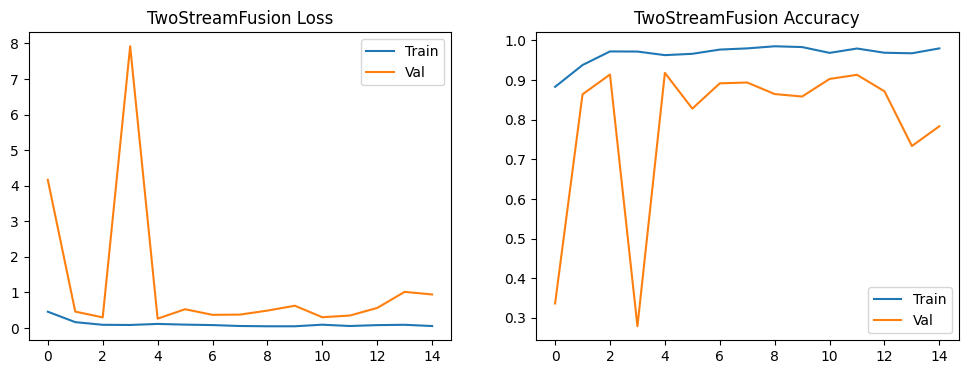

In [ ]:

plot_training_history(raw_hist, "RawOnly")
plot_training_history(spec_hist, "SpecOnly")
plot_training_history(fusion_hist, "TwoStreamFusion")


--- Raw Only Classification Report ---
              precision    recall  f1-score   support

        left       0.78      0.93      0.85       425
       right       0.90      0.66      0.76       406
          up       0.62      0.88      0.73       412
        down       0.90      0.56      0.69       396

    accuracy                           0.76      1639
   macro avg       0.80      0.76      0.76      1639
weighted avg       0.80      0.76      0.76      1639



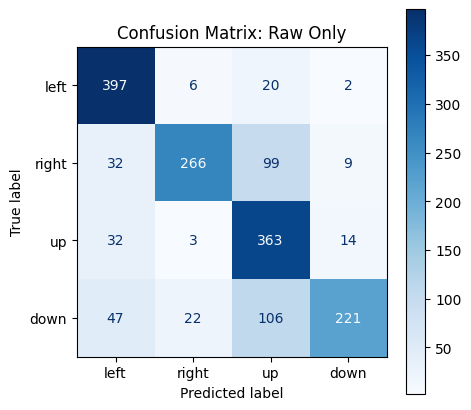


--- Spec Only Classification Report ---
              precision    recall  f1-score   support

        left       0.83      0.92      0.87       425
       right       0.94      0.82      0.87       406
          up       0.94      0.82      0.88       412
        down       0.84      0.95      0.89       396

    accuracy                           0.88      1639
   macro avg       0.88      0.88      0.88      1639
weighted avg       0.88      0.88      0.88      1639



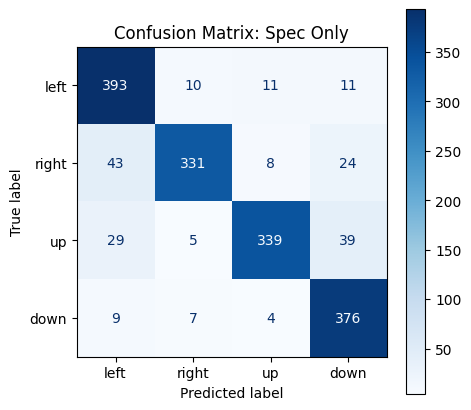


--- Two-Stream Fusion Classification Report ---
              precision    recall  f1-score   support

        left       0.88      0.99      0.93       425
       right       0.94      0.86      0.90       406
          up       0.93      0.95      0.94       412
        down       0.97      0.91      0.94       396

    accuracy                           0.93      1639
   macro avg       0.93      0.93      0.93      1639
weighted avg       0.93      0.93      0.93      1639



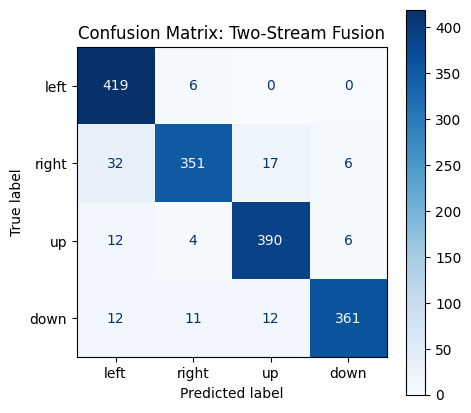

In [ ]:

comparison_results = run_final_evaluation(
    {"Raw Only": raw_model, "Spec Only": spec_model, "Two-Stream Fusion": fusion_model},
    test_loader,
    TARGET_LABELS
)

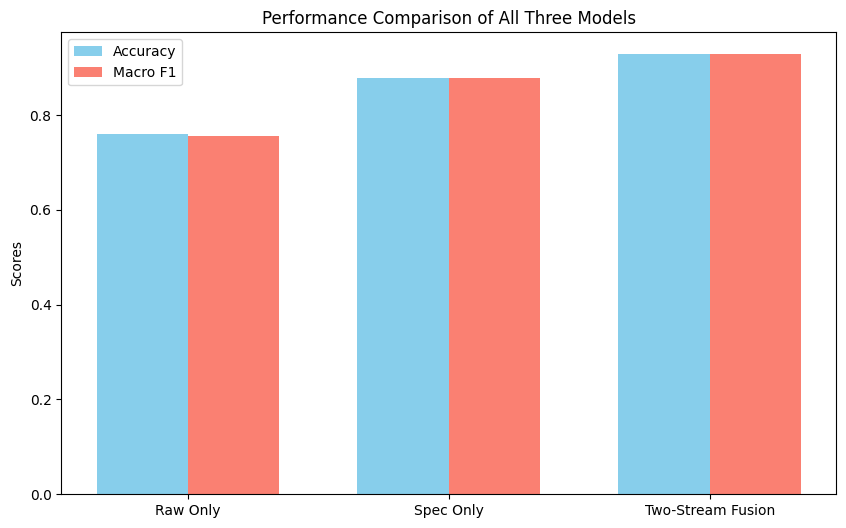

In [ ]:

plot_comparison_histogram(comparison_results)

In [ ]:
def verify_fusion_logic(model, loader, device):
    model.eval()
    raw, spec, y = next(iter(loader))

    raw = raw.to(device)
    spec = spec.to(device)
    print("\nInput Data Shapes")
    print(f"Raw Signal Batch:   {raw.shape}  (Expected: [Batch, 16000])")
    print(f"Spectrogram Batch:  {spec.shape} (Expected: [Batch, 1, Freq, Time])")

    with torch.no_grad():
        x_raw_input = raw.unsqueeze(1) if raw.dim() == 2 else raw
        raw_feat = model.raw_features(x_raw_input)
        zr = model.raw_proj(raw_feat)
        spec_feat = model.spec_features(spec)
        zs = model.spec_proj(spec_feat)
        print(f"Raw Embedding (zr):  {zr.shape} (Expected: [Batch, emb_dim])")
        print(f"Spec Embedding (zs): {zs.shape} (Expected: [Batch, emb_dim])")
        z = torch.cat([zr, zs], dim=1)
        print(f"Concatenated (z):    {z.shape} (Expected: [Batch, 2 * emb_dim]) ")
        logits = model.fusion_head(z)
        print(f"Final Logits:        {logits.shape} (Expected: [Batch, Num_Classes])")
    input_match = (zr.shape[1] == zs.shape[1])
    concat_match = (z.shape[1] == zr.shape[1] + zs.shape[1])

verify_fusion_logic(fusion_model, train_loader, device)


Input Data Shapes
Raw Signal Batch:   torch.Size([128, 16000])  (Expected: [Batch, 16000])
Spectrogram Batch:  torch.Size([128, 1, 513, 32]) (Expected: [Batch, 1, Freq, Time])
Raw Embedding (zr):  torch.Size([128, 128]) (Expected: [Batch, emb_dim])
Spec Embedding (zs): torch.Size([128, 128]) (Expected: [Batch, emb_dim])
Concatenated (z):    torch.Size([128, 256]) (Expected: [Batch, 2 * emb_dim]) 
Final Logits:        torch.Size([128, 4]) (Expected: [Batch, Num_Classes])


Q: A discussion explaining whether feature fusion improves performance and why.

1. Complementary Robustness: Feature fusion integrates frequency-domain and time-domain perspectives, allowing the model to maintain accuracy even if environmental noise compromises one data source. While noise might obscure spectral peaks, the raw audio stream provides a reliable backup by identifying the word's unique rhythmic and temporal patterns.

2. Reduction of Learning: Fusion prevents the model from relying on "shortcuts," which are irrelevant noise patterns that might correlate with labels in a single data stream.

3. Feature Filtration: Compressing 512 features into a 128-dimensional "bottleneck" filters out redundant data and high-frequency noise through non-linear compression.

Q: Observations on which classes benefit most from fusion.

ANS: The Left and Up label benefited greatly in fusion model as the F1 score for Left and Up label got upto 0.93 and 0.94 respectively. The true positive rate for Up label rose significantly compared to other two models indicating the most benefited feature for this model. This is due to the reason that in other models the false positive rates were relatively higher whereas in fusion model those rates essentially came down which resulted in higher number of true positive for Up label.

